In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import log_loss, accuracy_score, classification_report, roc_auc_score, \
confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
RSEED=42

In [2]:
# Import data
df=pd.read_csv('data/Train.csv')
df.head(3)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0


In [5]:
print(df.shape)

(4809, 23)


# Data cleaningin and feature engineering

In [7]:
# Check data info and show the data type of each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

In [8]:
# Select numeric columns
df.select_dtypes('number')

,total_female,total_male,night_mainland,night_zanzibar,total_cost
0,1.0,1.0,13.0,0.0,674602.5
1,1.0,0.0,14.0,7.0,3214906.5
2,0.0,1.0,1.0,31.0,3315000.0
3,1.0,1.0,11.0,0.0,7790250.0
4,1.0,0.0,7.0,4.0,1657500.0
...,...,...,...,...,...
4804,0.0,1.0,2.0,0.0,3315000.0
4805,1.0,1.0,11.0,0.0,10690875.0
4806,1.0,0.0,3.0,7.0,2246636.7
4807,1.0,1.0,5.0,0.0,1160250.0


As we can see only the columns total_female, total_male, night_mainland and nigh_zanzibar are read as floats.

The columns with object dtype are possible categorical features in our dataset.

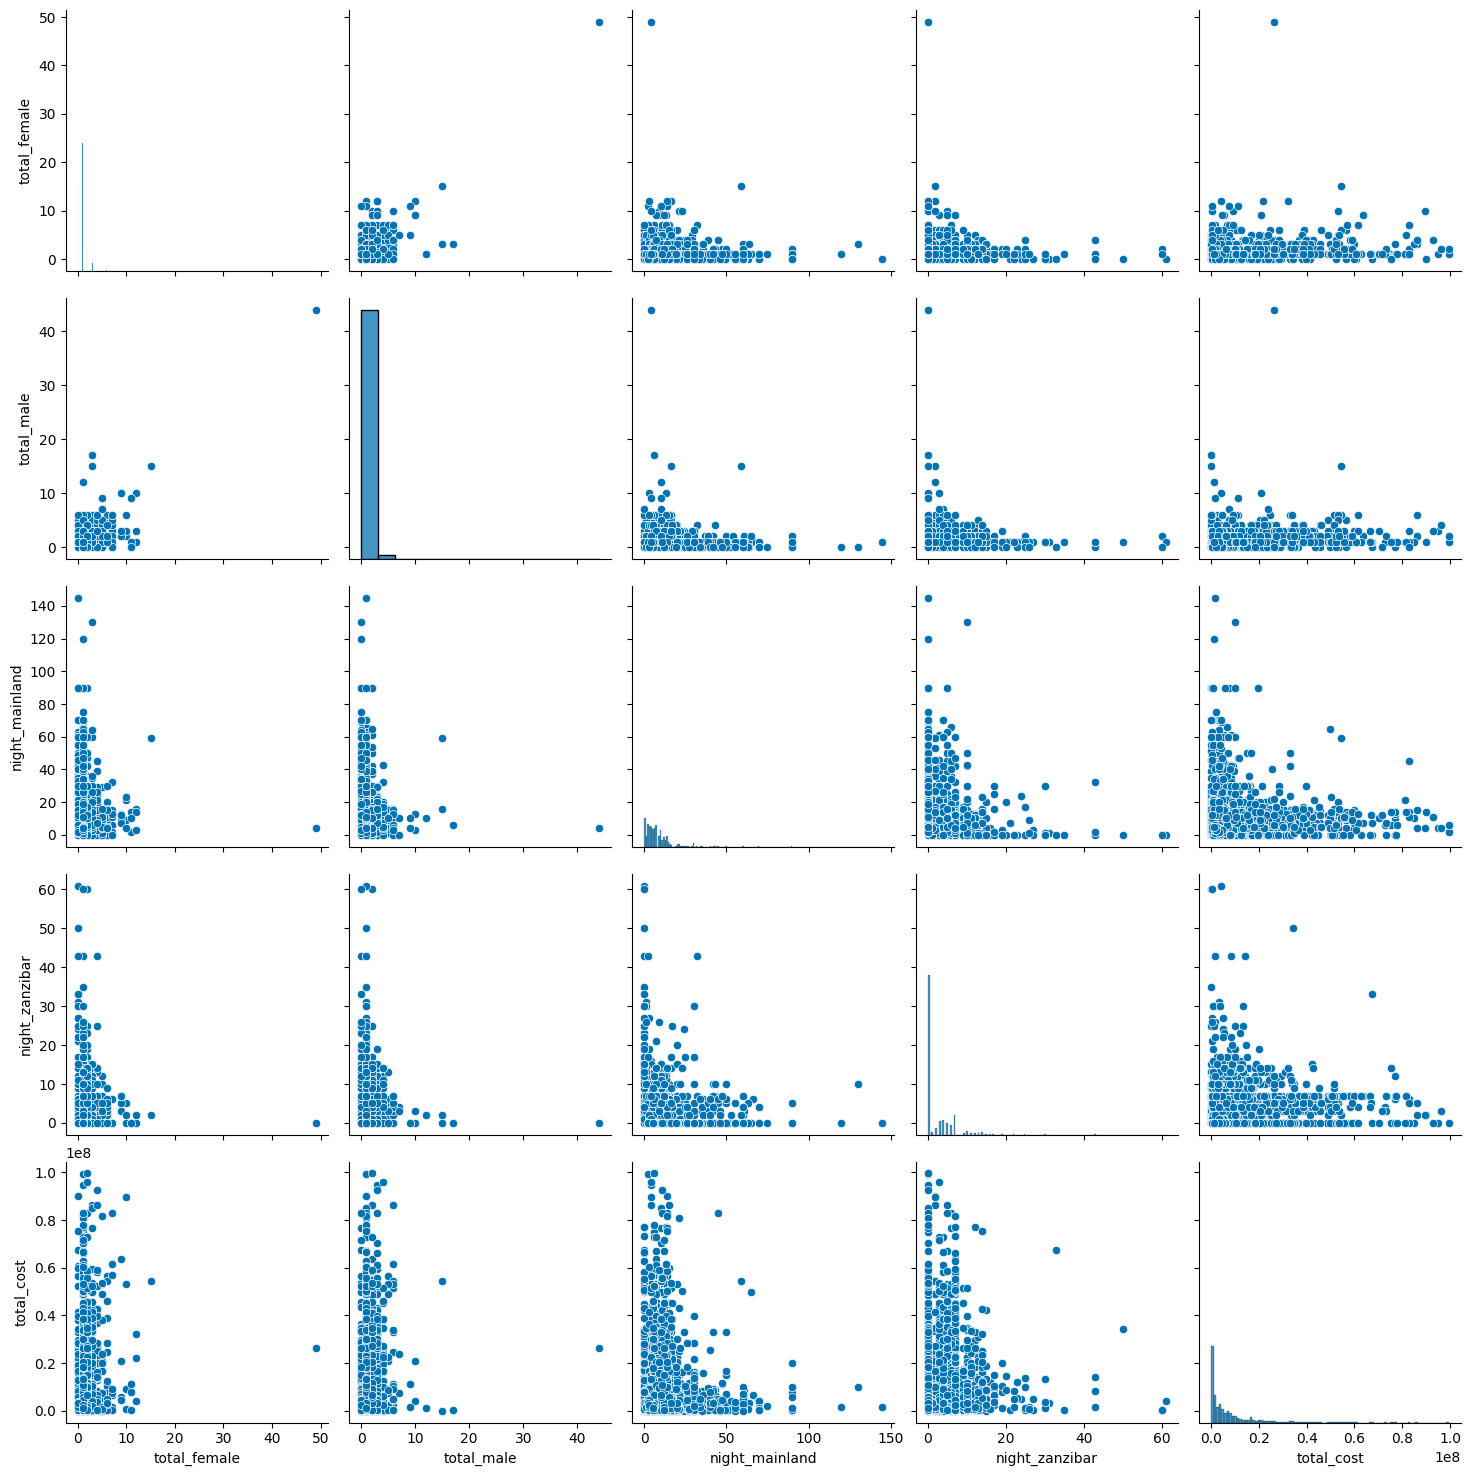

In [9]:
# Visualize the data using scatter plot and histogram
sns.set_palette('colorblind')
sns.pairplot(data=df, height=3)


In [10]:

df.corr()



,total_female,total_male,night_mainland,night_zanzibar,total_cost
total_female,1.000000,0.471180,0.031200,0.138555,0.286097
total_male,0.471180,1.000000,-0.041964,0.050318,0.185848
night_mainland,0.031200,-0.041964,1.000000,-0.118155,0.020473
night_zanzibar,0.138555,0.050318,-0.118155,1.000000,0.145139
total_cost,0.286097,0.185848,0.020473,0.145139,1.000000


<AxesSubplot:>

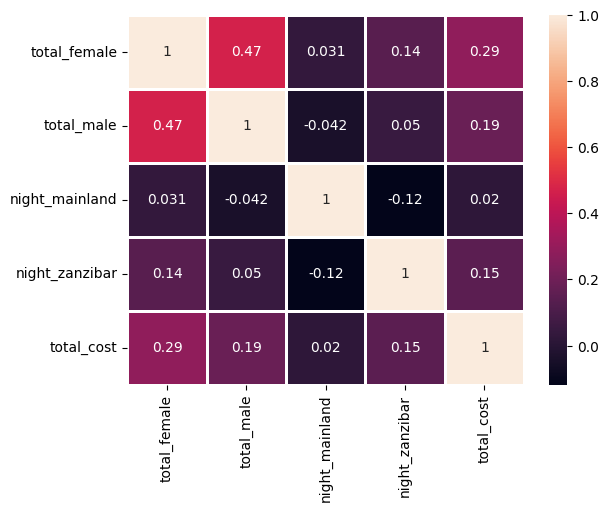

In [11]:
sns.heatmap(df.corr(),annot=True,lw=1)

### Missing Values

In the following we will take care about this missing data.

One of the most common data pre-processing steps is to check for null values in the dataset.

In [119]:
#print the total number of missing values
print(df.isnull().values.sum())

1114


In [120]:
#display number of missing values per column
print(df.isnull().sum())

ID                          0
country                     0
age_group                   0
travel_with              1114
total_female                0
total_male                  0
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing             0
total_cost                  0
total_cost_euro             0
customer_segmentation       0
dtype: int64


In [121]:
print(f"numbers of duplicated rows : {df.shape[0]}")
print(f"missing values in travel with : {round(df.travel_with.isna().sum()/df.shape[0]*100,2)} %")
print(f"missing values in total_female : {round(df.total_female.isna().sum()/df.shape[0]*100,2)} %")
print(f"missing values in total_male : {round(df.total_male.isna().sum()/df.shape[0]*100,2)} %")
print(f"missing values in most_impressing : {round(df.most_impressing.isna().sum()/df.shape[0]*100,2)} %")

numbers of duplicated rows : 4809
missing values in travel with : 23.16 %
missing values in total_female : 0.0 %
missing values in total_male : 0.0 %
missing values in most_impressing : 0.0 %


As we can see, we have a lot of missing values.

We can identify that in the column travel_with we have too many missing values (> 20%) and total_female, total_maleand most_impressing are candidates for imputation (< 10%).

We want to check the frequency distribution of categories within the feature.

In [122]:
print(df.travel_with.value_counts())
print("count of missing values in travel_with: ", df.travel_with.isna().sum())


Alone                  1265
Spouse                 1005
Friends/Relatives       895
Spouse and Children     368
Children                162
Name: travel_with, dtype: int64
count of missing values in travel_with:  1114


In [123]:
print(df.total_female.value_counts())
print("count of missing values in total_female: ", df.total_female.isna().sum())

1.0     2421
0.0     1669
2.0      463
3.0      144
4.0       46
5.0       25
6.0       15
7.0       10
10.0       4
9.0        4
12.0       3
11.0       3
15.0       1
49.0       1
Name: total_female, dtype: int64
count of missing values in total_female:  0


In [124]:
print(df.total_male.value_counts())
print("count of missing values in total_male: ", df.total_male.isna().sum())


1.0     2966
0.0     1137
2.0      478
3.0      139
4.0       46
6.0       17
5.0       15
15.0       2
7.0        2
10.0       2
9.0        2
17.0       1
12.0       1
44.0       1
Name: total_male, dtype: int64
count of missing values in total_male:  0


In [125]:
df[['travel_with', 'total_female', 'total_male']]
df['travel_with'].isnull()

0       False
1        True
2       False
3       False
4        True
        ...  
4804    False
4805    False
4806     True
4807    False
4808    False
Name: travel_with, Length: 4809, dtype: bool

As we can see Pandas recognized the "NAN" as a missing value.

In the following we want to get a deeper look in the columns with missing values.

In [126]:
#make a DataFrame with the missing values in "travel_with"
df_travel = pd.DataFrame(df[df['travel_with'].isnull()])
df_travel[['total_male', 'total_female', 'travel_with']]

,total_male,total_female,travel_with
1,0.0,1.0,NaN
4,0.0,1.0,NaN
5,1.0,0.0,NaN
17,0.0,1.0,NaN
19,0.0,1.0,NaN
...,...,...,...
4783,0.0,1.0,NaN
4788,1.0,0.0,NaN
4791,0.0,1.0,NaN
4798,0.0,1.0,NaN


In [127]:
#make a DataFrame with the missing values in "total_male"
df_male = pd.DataFrame(df[df['total_male'].isna()])
df_male[['total_male', 'total_female', 'travel_with']]

,total_male,total_female,travel_with


In [128]:
#make a DataFrame with the missing values in "total_female"
df_female = pd.DataFrame(df[df['total_female'].isnull()])
df_female[['total_male', 'total_female', 'travel_with']]

,total_male,total_female,travel_with


In [129]:
#make a DataFrame with the missing values in "most_impressing"
df_impressing = pd.DataFrame(df[df['most_impressing'].isnull()])
df_impressing[['most_impressing', 'travel_with', 'first_trip_tz']]

,most_impressing,travel_with,first_trip_tz


In [130]:
#replace the `NaN`-character with "Alone" 
df.travel_with.fillna('Alone',inplace=True)
df.travel_with.isna().sum()

0

In [135]:

#replace the `NaN`-character with "Friendly People" 
df.most_impressing.fillna('Friendly People',inplace=True)
df.most_impressing.isna().sum()

0

For the missing values in total_maleand total_female we just take the mode value.

In [136]:
df.total_female.fillna(df.total_female.mode()[0],inplace = True)

df.total_male.fillna(df.total_female.mode()[0],inplace = True)

Let's check the number of null values after cleaning the data.

In [137]:
print(df.isnull().values.sum())

0


Great. No missing values.

In [138]:
# convert float dtypes to int[total_female,total_male,night_mainland,night_zanzibar]
df["total_female"] = df['total_female'].astype('int')
df["total_male"] = df['total_male'].astype('int')
df["night_mainland"] = df['night_mainland'].astype('int')
df["night_zanzibar"] = df['night_zanzibar'].astype('int')

We renamed the columns of total_female, total_male and most_impressing to female, male and customer_feedback, respectively.

In [139]:
df.rename(columns={"total_female":"female","total_male":"male", "most_impressing":"customer_feedback"}, inplace = True)


In [140]:
#generate new features from some numerical columns
df["total_nights"] = df["night_mainland"] + df["night_zanzibar"]
df["number_of_people"] = df["female"] + df["male"]
df.columns

Index(['ID', 'country', 'age_group', 'travel_with', 'female', 'male',
       'purpose', 'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'customer_feedback', 'total_cost', 'total_cost_euro',
       'customer_segmentation', 'total_nights', 'number_of_people'],
      dtype='object')

We can see that ID variable isn't providing any information for our model, so we can drop them too.

In [141]:
# drop ID Column
df.drop('ID', axis='columns', inplace=True)

In [142]:
df.country = df.country.replace("SWIZERLAND", "SWITZERLAND")
df.country = df.country.replace("BURGARIA","BULGARIA")
df.country = df.country.replace("MALT","MALTA")
df.country = df.country.replace("DRC","DEMOCRATIC REPUBLIC OF THE CONGO")
df.country = df.country.replace("DRC","DEMOCRATIC REPUBLIC OF THE CONGO")
df.country = df.country.replace("SCOTLAND","UNITED KINGDOM")
df.country = df.country.replace("UAE","UNITED ARAB EMIRATES")
df.country = df.country.replace("PHILIPINES","PHILIPPINES")
df.country = df.country.replace("DJIBOUT","DJIBOUTI")
df.country = df.country.replace("MORROCO","MOROCCO")

In [143]:
# transform total_cost in euro and create a new column `total_cost_euro`
df.eval('total_cost_euro = total_cost* 0.00044', inplace = True)

In the following we want to classify the countries by continents. To do so we used the country_converter package and created a new column continent.

In [144]:
!pip install country-converter
import country_converter as coco

cc = coco.CountryConverter()
iso3 = np.array([])
for i in range(0, len(df)):
    iso3= np.append(iso3, cc.convert(names=df['country'][i], to='ISO3' ))
df['ISO3'] = pd.DataFrame(iso3) 

In [145]:
cc = coco.CountryConverter()
continent = np.array([])
for i in range(0, len(df)):
    continent = np.append(continent, cc.convert(names=df['country'][i], to='continent' ))
df['continent'] = pd.DataFrame(continent) 
df.columns

Index(['country', 'age_group', 'travel_with', 'female', 'male', 'purpose',
       'main_activity', 'info_source', 'tour_arrangement',
       'package_transport_int', 'package_accomodation', 'package_food',
       'package_transport_tz', 'package_sightseeing', 'package_guided_tour',
       'package_insurance', 'night_mainland', 'night_zanzibar', 'payment_mode',
       'first_trip_tz', 'customer_feedback', 'total_cost', 'total_cost_euro',
       'customer_segmentation', 'total_nights', 'number_of_people', 'ISO3',
       'continent'],
      dtype='object')

Let's take a look of the new dataset we created.

In [146]:
df.head()

,country,age_group,travel_with,female,male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,payment_mode,first_trip_tz,customer_feedback,total_cost,total_cost_euro,customer_segmentation,total_nights,number_of_people,ISO3,continent
0,SWITZERLAND,45-64,Friends/Relatives,1,1,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,...,Cash,No,Friendly People,674602.5,296.82510,low cost,13,2,CHE,Europe
1,UNITED KINGDOM,25-44,Alone,1,0,Leisure and Holidays,Cultural tourism,others,Independent,No,...,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5,1414.55886,low cost,21,1,GBR,Europe
2,UNITED KINGDOM,25-44,Alone,0,1,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,...,Cash,No,Excellent Experience,3315000.0,1458.60000,low cost,32,1,GBR,Europe
3,UNITED KINGDOM,25-44,Spouse,1,1,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,...,Cash,Yes,Friendly People,7790250.0,3427.71000,low cost,11,2,GBR,Europe
4,CHINA,1-24,Alone,1,0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,...,Cash,Yes,No comments,1657500.0,729.30000,low cost,11,1,CHN,Asia


Dealing with outliers

In [147]:
###removing outliers Inter-quartile Range (IQR)
###IQR = Q3-Q1
###Lower Boundary = Q1-1.5*IQR
###Upper Boundary = Q3+1.5*IQR

def outliers(df,ft):
    Q1 = df[ft].quantile(0.25)
    Q3 = df[ft].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR

    ls = df.index[(df[ft] < lower_bound)| (df[ft] > upper_bound)]
    return ls

In [148]:
#create an empty list to store the output indices from multiple columns
index_list = []
for feature in ['night_mainland','night_zanzibar','total_cost_euro']:
    index_list.extend(outliers(df,feature))

In [149]:
def remove(df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [150]:
df_outliers=remove(df,index_list)

In [151]:
df_outliers=remove(df,index_list)

Save the data

In [152]:
#df_outliers.to_csv('data/df_clean.csv',index=False)
#df_new = pd.read_csv('data/df_clean.csv')

#df.to_csv('data/df_clean.csv',index=False)
#df_new = pd.read_csv('data/df_clean.csv')

### Categorical variables

In the following we want to find out if the variables could be categorical or numeric. We will take a closer look at the columns age-group, travel_with, purpose, info_source, tour_arrangement and main_activity.

An EDA step that we want to go on categorical data is the distribution of categories within the feature.

In the following we want to find out if the variables could be categorical or numeric. We will take a closer look at the columns age-group, travel_with, purpose, info_source, tour_arrangement and main_activity.

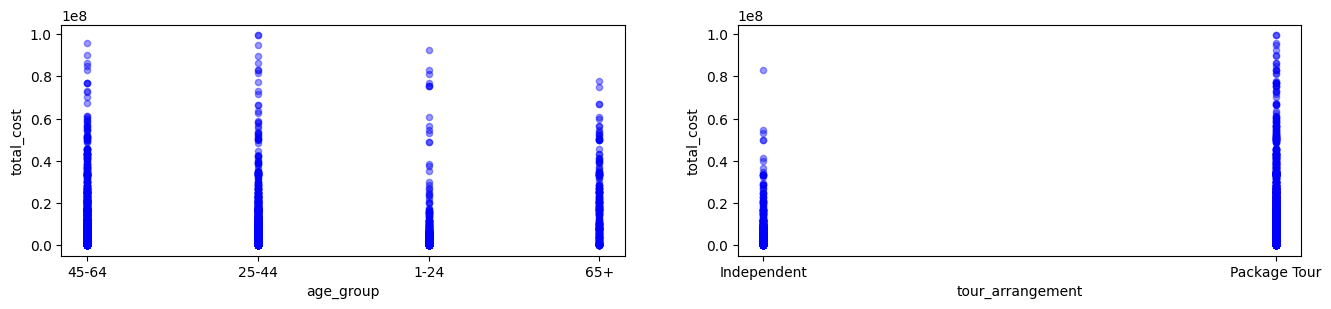

In [153]:
# Create plots to identify categorical features
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

for xcol, ax in zip(['age_group', 'tour_arrangement'], axes):
    df.plot(kind='scatter', x=xcol, y='total_cost', ax=ax, alpha=0.4, color='b')

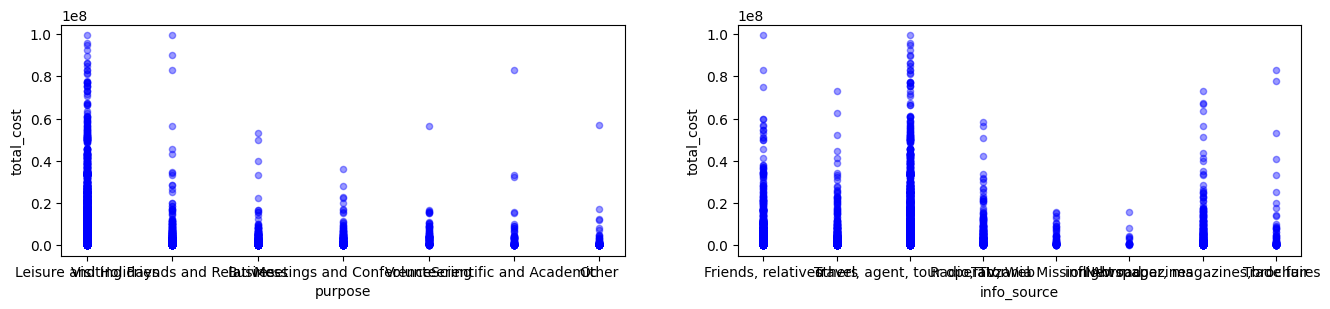

In [154]:
# Create plots to identify categorical features
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

for xcol, ax in zip(['purpose', 'info_source'], axes):
    df.plot(kind='scatter', x=xcol, y='total_cost', ax=ax, alpha=0.4, color='b')

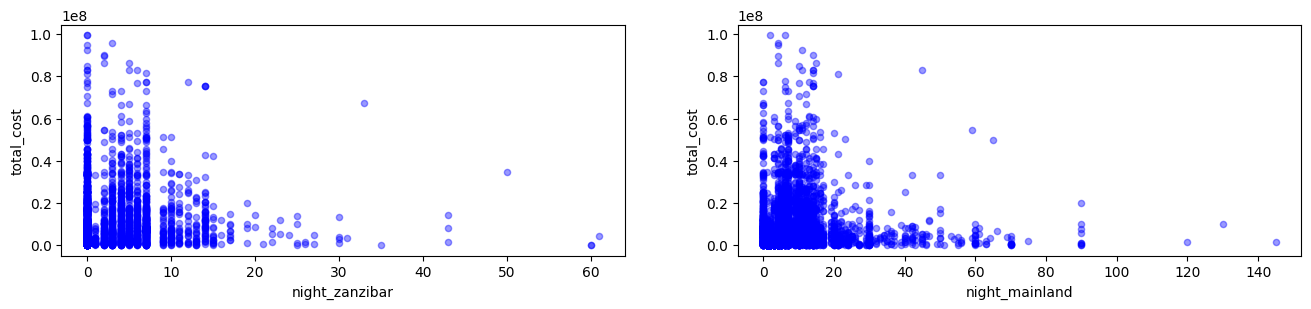

In [155]:
# Create plots to identify categorical features
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,3))

for xcol, ax in zip(['night_zanzibar', 'night_mainland'], axes):
    df.plot(kind='scatter', x=xcol, y='total_cost', ax=ax, alpha=0.4, color='b')

In [156]:
# Descriptive statistics for column age_group
print(df.age_group.value_counts())
print("The count of distinct categories is: ",df.age_group.value_counts().count())

25-44    2487
45-64    1391
1-24      624
65+       307
Name: age_group, dtype: int64
The count of distinct categories is:  4


In [157]:
# Descriptive statistics for column travel_with
print(df.travel_with.value_counts())
print("The count of distinct categories is: ", df.travel_with.value_counts().count())

Alone                  2379
Spouse                 1005
Friends/Relatives       895
Spouse and Children     368
Children                162
Name: travel_with, dtype: int64
The count of distinct categories is:  5


In [158]:
# Descriptive statistics for column purpose
print(df.purpose.value_counts())
print("The count of distinct categories is: ", df.purpose.value_counts().count())

Leisure and Holidays              2840
Business                           671
Visiting Friends and Relatives     633
Meetings and Conference            312
Volunteering                       138
Other                              128
Scientific and Academic             87
Name: purpose, dtype: int64
The count of distinct categories is:  7


In [159]:
# Descriptive statistics for column main_activity
print(df.main_activity.value_counts())
print("The count of distinct categories is: ", df.main_activity.value_counts().count())

Wildlife tourism            2259
Beach tourism               1025
Hunting tourism              457
Conference tourism           367
Cultural tourism             359
Mountain climbing            234
business                      58
Bird watching                 37
Diving and Sport Fishing      13
Name: main_activity, dtype: int64
The count of distinct categories is:  9


In [160]:
# Descriptive statistics for column info_source
print(df.info_source.value_counts())
print("The count of distinct categories is: ", df.info_source.value_counts().count())

Travel, agent, tour operator      1913
Friends, relatives                1635
others                             490
Newspaper, magazines,brochures     359
Radio, TV, Web                     249
Trade fair                          77
Tanzania Mission Abroad             68
inflight magazines                  18
Name: info_source, dtype: int64
The count of distinct categories is:  8


In [161]:
# Descriptive statistics for column tour_arrangement
print(df.tour_arrangement.value_counts())
print("The count of distinct categories is: ", df.tour_arrangement.value_counts().count())

Independent     2570
Package Tour    2239
Name: tour_arrangement, dtype: int64
The count of distinct categories is:  2


In [162]:
# Descriptive statistics for column payment_mode
print(df.payment_mode.value_counts())
print("The count of distinct categories is: ", df.payment_mode.value_counts().count())

Cash                 4172
Credit Card           622
Other                   8
Travellers Cheque       7
Name: payment_mode, dtype: int64
The count of distinct categories is:  4


We have many categorical values to do with

In [163]:
df_country = df.groupby(['country'])['total_cost_euro'].sum().rename("total_cost_by_country")
df_country= df_country.to_frame().reset_index()
df_country.head(10)

,country,total_cost_by_country
0,ALGERIA,2.007763e+03
1,ANGOLA,2.200000e+02
2,ARGENTINA,4.594590e+03
3,AUSTRALIA,1.206978e+06
4,AUSTRIA,6.050950e+04
5,BELGIUM,1.866418e+05
6,BERMUDA,8.800000e+01
7,BRAZIL,3.438324e+04
8,BULGARIA,4.217169e+02
9,BURUNDI,2.295217e+04


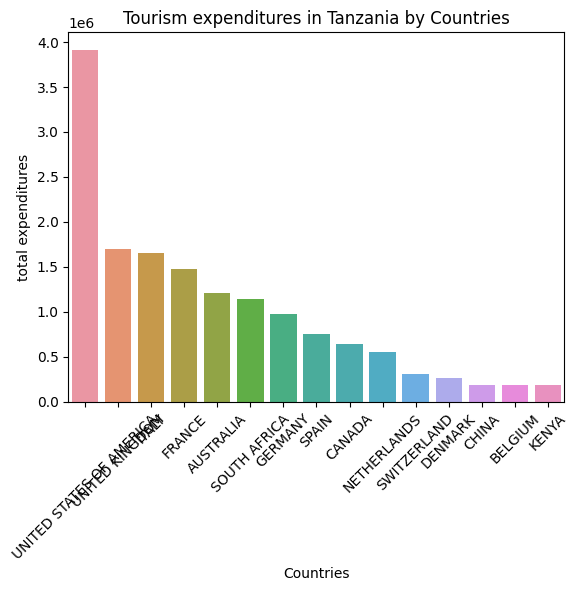

In [164]:
df_country_sort= df_country.sort_values(['total_cost_by_country'],ascending=False).head(15)

sns.barplot(x='country', y='total_cost_by_country', data=df_country_sort)

plt.xticks(rotation=45)
plt.ylabel("total expenditures")
plt.xlabel("Countries")
plt.title("Tourism expenditures in Tanzania by Countries")
plt.show()

In the following we want to analyze the people with tour arrangement who spend more money then people who go independently.

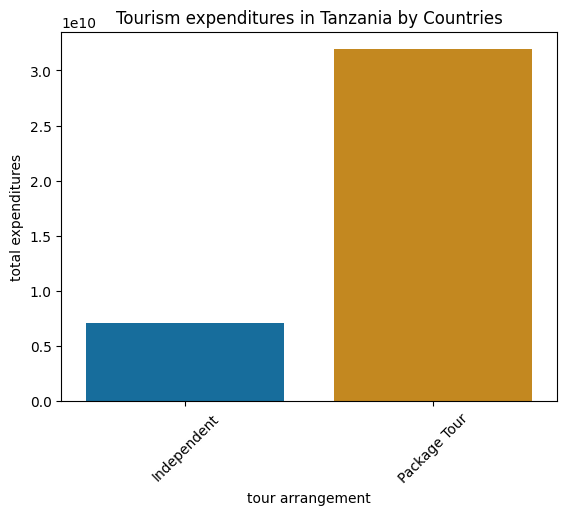

In [165]:
df_country_arrangment = df.groupby(['tour_arrangement'])['total_cost'].sum().rename("total_cost_by_country")
df_country_arrangment= df_country_arrangment.to_frame().reset_index()

sns.barplot(x='tour_arrangement', y='total_cost_by_country', data=df_country_arrangment)

plt.xticks(rotation=45)
plt.ylabel("total expenditures")
plt.xlabel("tour arrangement")
plt.title("Tourism expenditures in Tanzania by Countries")
plt.show()

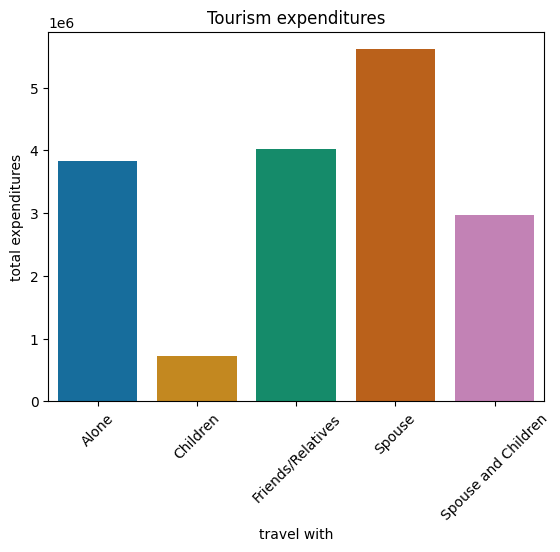

In [166]:
df_country = df.groupby(['travel_with'])['total_cost_euro'].sum().rename("travel_cost_by_travel_with")
df_country= df_country.to_frame().reset_index()

sns.barplot(x='travel_with', y='travel_cost_by_travel_with', data=df_country)

plt.xticks(rotation=45)
plt.ylabel("total expenditures")
plt.xlabel("travel with")
plt.title("Tourism expenditures")
plt.show()

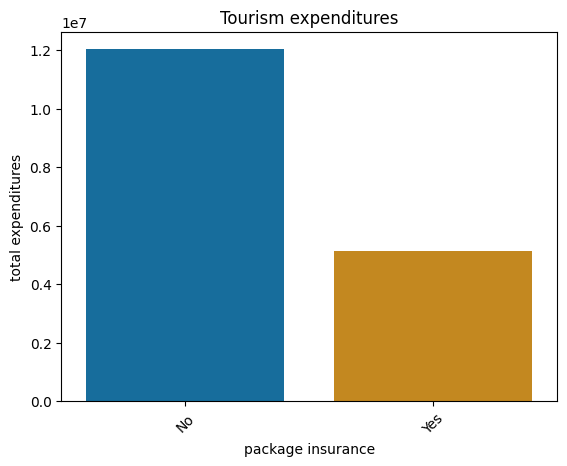

In [167]:
df_package_insurance= df.groupby(['package_insurance'])['total_cost_euro'].sum().rename("total_cost_by_insurance")
df_package_insurance= df_package_insurance.to_frame().reset_index()

sns.barplot(x='package_insurance', y='total_cost_by_insurance', data=df_package_insurance)

plt.xticks(rotation=45)
plt.ylabel("total expenditures")
plt.xlabel("package insurance")
plt.title("Tourism expenditures")
plt.show()

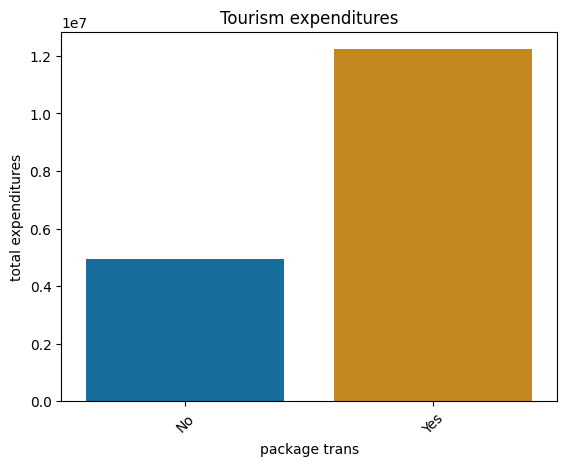

In [168]:
df_package_trans= df.groupby(['package_transport_tz'])['total_cost_euro'].sum().rename("total_cost_by_trans")
df_package_trans= df_package_trans.to_frame().reset_index()

sns.barplot(x='package_transport_tz', y='total_cost_by_trans', data=df_package_trans)

plt.xticks(rotation=45)
plt.ylabel("total expenditures")
plt.xlabel("package trans")
plt.title("Tourism expenditures")
plt.show()

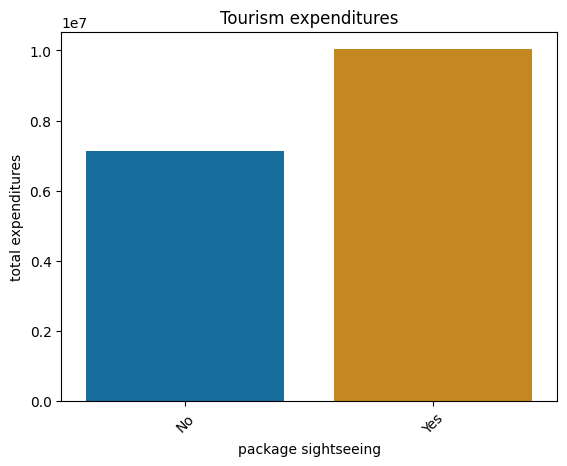

In [60]:
df_package_sightseeing= df.groupby(['package_sightseeing'])['total_cost_euro'].sum().rename("total_cost_by_sightseeing")
df_package_sightseeing= df_package_sightseeing.to_frame().reset_index()

sns.barplot(x='package_sightseeing', y='total_cost_by_sightseeing', data=df_package_sightseeing)

plt.xticks(rotation=45)
plt.ylabel("total expenditures")
plt.xlabel("package sightseeing")
plt.title("Tourism expenditures")
plt.show()

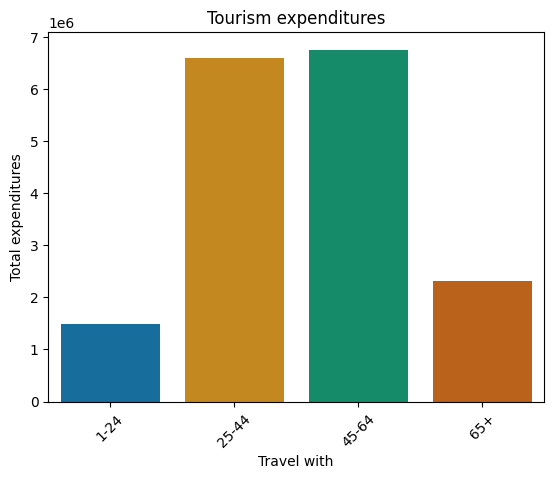

In [61]:
df_age= df.groupby(['age_group'])['total_cost_euro'].sum().rename("total_cost_by_age")
df_age= df_age.to_frame().reset_index()

sns.barplot(x='age_group', y='total_cost_by_age', data=df_age)

plt.xticks(rotation=45)
plt.ylabel("Total expenditures")
plt.xlabel("Travel with")
plt.title("Tourism expenditures")
plt.show()

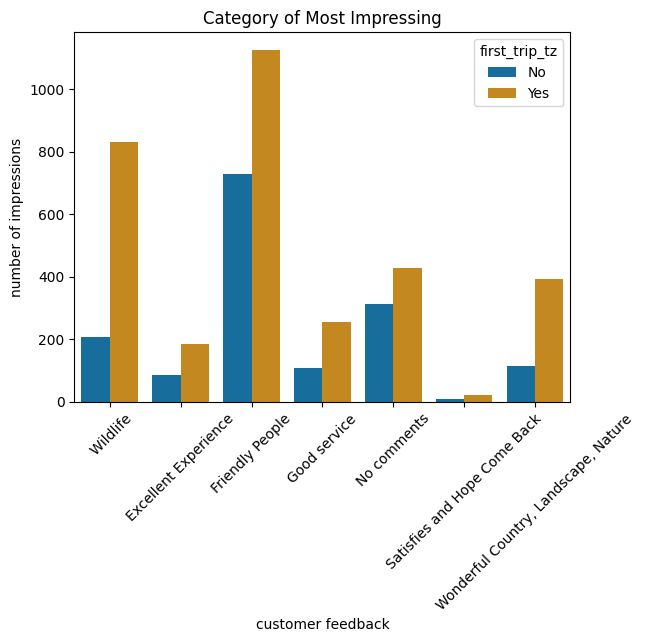

In [62]:
df_package_by_most_impressing= df.groupby(['customer_feedback','first_trip_tz'])['first_trip_tz'].count().rename("count_of_trip_tz")
df_package_by_most_impressing= df_package_by_most_impressing.to_frame().reset_index()

#people who left feed back as "Friendly people" are highly like to come back to Tanzania
sns.barplot(x='customer_feedback', y='count_of_trip_tz', data=df_package_by_most_impressing,hue = 'first_trip_tz')

plt.xticks(rotation=45)
plt.ylabel("number of impressions")
plt.xlabel("customer feedback")
plt.title("Category of Most Impressing")
plt.show()

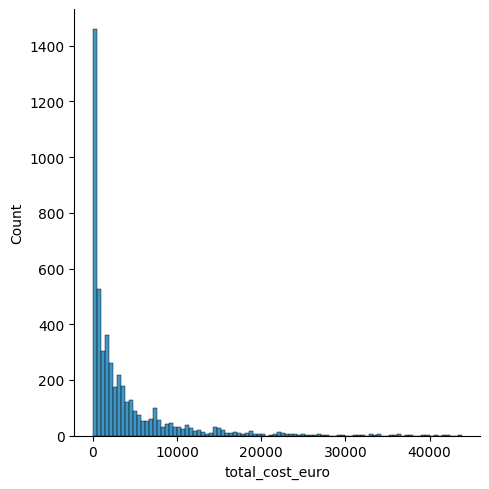

In [63]:
sns.displot(df, x="total_cost_euro")

Training the model


Linear Regression


In our dataset, there is more than one categorical column. We want to use categorical variables in our regression model. Thus, they need to be transformed.

We create the preprocessing pipelines for both numeric and categorical data.

### Splitting data for testing

A QuantileTransformer is used to normalize the target distribution before applying a LinearRegression model.

In [169]:
X = df.drop(['total_cost','total_cost_euro'], axis=1)
y = df.total_cost_euro

#transform the targets before learning a model
y_tran = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

In [171]:
num_features = list(X.select_dtypes(include=['int64', 'float64']).columns)
#num_features = list(df.select_dtypes(include=['int64', 'float64']).columns)
#num_features.remove('total_cost')
#num_features.remove('total_cost_euro')


numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler())
])

#categorical_features = list(df.select_dtypes(include=['object']).columns)
categorical_features = list(X.select_dtypes(include=['object']).columns)

categorical_transformer =OneHotEncoder(handle_unknown="ignore")

#combine the two preprocessed steps together
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

A ColumnTransformer takes in a list, which contains tuples of the transformations we wish to perform on the different columns. Each tuple expects 3 comma-separated values: first, the name of the transformer, which can be practically anything (passed as a string), second is the estimator object, and the final one being the columns upon which we wish to perform that operation.

### Training the model

In [172]:
model = LinearRegression()
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("model", model)]
)

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_tran, test_size=0.2, random_state=RSEED)

X_train_tran, X_test_tran, y_train_tran, y_test_tran = train_test_split(X, y_tran, test_size=0.2, random_state=RSEED)

In [113]:
## in order to exemplify how the predict will work.. we will save the y_train
#X_test.to_csv("data/X_test.csv")
#y_test.to_csv("data/y_test.csv")

In [173]:
#fit the model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['female', 'male',
                                                   'night_mainland',
                                                   'night_zanzibar',
                                                   'total_nights',
                                                   'number_of_people']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'age_group',
                                                   'travel_with', 'purpose',
                                                   'main_activity',
                                 

In [174]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(4809, 26)
(3847, 26)
(962, 26)


### Evaluate the trained model

In [78]:
print("train score: ", clf.score(X_train, y_train))
print("test score: ", clf.score(X_test, y_test))

train score:  0.5630758483056005
test score:  0.5073521826900189


In [79]:
# making predictions
y_pred = clf.predict(X_test)

In [80]:
# model evaluation
score=r2_score(y_test, y_pred)
print("r2 score (R2): ",score)
print("mean_sqrd_error (MSE): ",mean_squared_error(y_test,y_pred))
print('mean_absolute_error (MAE): ', mean_absolute_error(y_test, y_pred))
print("root_mean_squared error (RMSE): ",np.sqrt(mean_squared_error(y_test, y_pred)))

r2 score (R2):  0.5073521826900189
mean_sqrd_error (MSE):  0.4635091850195023
mean_absolute_error (MAE):  0.504548132788632
root_mean_squared error (RMSE):  0.6808150887131559


### XGBoost

In [175]:
!pip install xgboost
from xgboost import XGBRegressor

In [176]:
xcg_boost = Pipeline(
    steps=[("preprocessor", preprocessor), 
    ("regressor", XGBRegressor())]
)

#fit the model
xcg_boost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['female', 'male',
                                                   'night_mainland',
                                                   'night_zanzibar',
                                                   'total_nights',
                                                   'number_of_people']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'age_group',
                                                   'travel_with', 'purpose',
                                                   'main_activity',
                                 

In [177]:
# making predictions
y_pred_xcg_boost = xcg_boost.predict(X_test)

### Logistic Regression

In [178]:
# create classes for the classification
customer_segmentation = []
for row in df['total_cost_euro']:
        if row < 5000 :    customer_segmentation.append('low cost')
        elif row < 10000:  customer_segmentation.append('medium cost')
        else:      customer_segmentation.append('high cost')

In [179]:
# create a new column 
df['customer_segmentation'] = customer_segmentation

In [180]:
df.head()

,country,age_group,travel_with,female,male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,payment_mode,first_trip_tz,customer_feedback,total_cost,total_cost_euro,customer_segmentation,total_nights,number_of_people,ISO3,continent
0,SWITZERLAND,45-64,Friends/Relatives,1,1,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,...,Cash,No,Friendly People,674602.5,296.82510,low cost,13,2,CHE,Europe
1,UNITED KINGDOM,25-44,Alone,1,0,Leisure and Holidays,Cultural tourism,others,Independent,No,...,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5,1414.55886,low cost,21,1,GBR,Europe
2,UNITED KINGDOM,25-44,Alone,0,1,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,...,Cash,No,Excellent Experience,3315000.0,1458.60000,low cost,32,1,GBR,Europe
3,UNITED KINGDOM,25-44,Spouse,1,1,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,...,Cash,Yes,Friendly People,7790250.0,3427.71000,low cost,11,2,GBR,Europe
4,CHINA,1-24,Alone,1,0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,...,Cash,Yes,No comments,1657500.0,729.30000,low cost,11,1,CHN,Asia


In [181]:
X = df.drop(['total_cost','total_cost_euro', 'customer_segmentation'], axis=1)
y = df.customer_segmentation

In [182]:
num_features = list(df.select_dtypes(include=['int64', 'float64']).columns)
num_features.remove('total_cost')
num_features.remove('total_cost_euro')


numeric_transformer = Pipeline([
    ('scaler', MinMaxScaler())
])

categorical_features = list(df.select_dtypes(include=['object']).columns)
categorical_features.remove('customer_segmentation')

categorical_transformer =OneHotEncoder(handle_unknown="ignore")

#combine the two preprocessed steps together
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [183]:
log_reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

log_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['female', 'male',
                                                   'night_mainland',
                                                   'night_zanzibar',
                                                   'total_nights',
                                                   'number_of_people']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country', 'age_group',
                                                   'travel_with', 'purpose',
                                                   'main_activity',
                                 

In [184]:
y_pred_train = log_reg.predict(X_train)
y_pred = log_reg.predict(X_test)

Accuracy on train set: 0.82
Accuracy on test set: 0.8
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

   high cost       0.50      0.43      0.46        96
    low cost       0.86      0.94      0.90       760
 medium cost       0.21      0.08      0.12       106

    accuracy                           0.80       962
   macro avg       0.52      0.48      0.49       962
weighted avg       0.75      0.80      0.77       962

--------------------------------------------------------------------------------


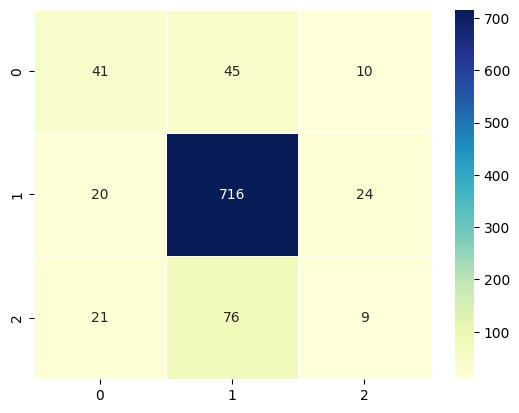

In [185]:
# Print accuracy of our model
print("Accuracy on train set:", round(accuracy_score(y_train, y_pred_train), 2))
print("Accuracy on test set:", round(accuracy_score(y_test, y_pred), 2))
print("--------"*10)

# Print classification report of our model
print(classification_report(y_test, y_pred))
print("--------"*10)

# Evaluate the model with a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);

We reached an accuracy of 0.82 on the train set and 0.80 on our test set.

If we have a look at the confusion matrix we can see that our model classified instances of high cost really as high cost by 0.43.

'low cost': 0.86 was predicted correctly and from all the classes we predicted as positive 0.94 are actually positive (716). 24 were falsly classified as medium cost.